# Classify Customer Churn

Here [CustomerChurnRate](https://www.kaggle.com/gangliu/customerchurnrate) dataset by [Gang Liu](https://www.kaggle.com/gangliu) is used classify whether a customer is going to churn or not. Using the dataset `EDA` is done.

**While doing this we'll**
- Deal with `outliers` using the `iqr` and `z-scores` methods
- Feature selection using `backward elimination`

![](https://media.giphy.com/media/xT5LMWN76TzT7t3kaI/giphy.gif)

In [1]:
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy.stats import pearsonr, zscore
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, learning_curve

# Algorithms
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

from joblib import dump

In [2]:
# Pandas config
def pandas_config():
    # display 10 rows and all the columns
    pd.set_option('display.max_rows', 10)
    pd.set_option('display.max_columns', None)


pandas_config()

In [3]:
def load_dataset():
    path = '/kaggle/input/customerchurnrate/ChurnData.csv'
    return pd.read_csv(path)


df = load_dataset()
df.sample(5)

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,tollmon,equipmon,cardmon,wiremon,longten,tollten,cardten,voice,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
199,61.0,50.0,16.0,190.0,2.0,22.0,1.0,1.0,1.0,16.85,0.00,42.55,26.50,44.10,1063.15,0.00,1600.0,0.0,0.0,1.0,0.0,0.0,1.0,2.824,3.240,5.247,2.0,0.0
77,10.0,34.0,1.0,52.0,5.0,3.0,1.0,0.0,1.0,4.30,0.00,32.55,0.00,25.40,47.45,0.00,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.459,3.240,3.951,2.0,1.0
44,33.0,33.0,12.0,42.0,4.0,7.0,1.0,1.0,1.0,8.80,0.00,30.95,23.00,23.35,305.75,0.00,730.0,1.0,0.0,0.0,0.0,0.0,0.0,2.175,3.240,3.738,2.0,0.0
71,54.0,27.0,3.0,27.0,2.0,6.0,1.0,1.0,1.0,12.40,35.00,48.30,5.75,43.50,660.85,1919.75,315.0,1.0,1.0,1.0,1.0,1.0,1.0,2.518,3.555,3.296,4.0,0.0
51,26.0,39.0,15.0,58.0,4.0,9.0,0.0,1.0,1.0,8.65,21.25,0.00,6.50,19.65,210.60,567.55,145.0,0.0,0.0,1.0,0.0,1.0,0.0,2.158,3.056,4.060,3.0,0.0


## Data Preparation

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tenure    200 non-null    float64
 1   age       200 non-null    float64
 2   address   200 non-null    float64
 3   income    200 non-null    float64
 4   ed        200 non-null    float64
 5   employ    200 non-null    float64
 6   equip     200 non-null    float64
 7   callcard  200 non-null    float64
 8   wireless  200 non-null    float64
 9   longmon   200 non-null    float64
 10  tollmon   200 non-null    float64
 11  equipmon  200 non-null    float64
 12  cardmon   200 non-null    float64
 13  wiremon   200 non-null    float64
 14  longten   200 non-null    float64
 15  tollten   200 non-null    float64
 16  cardten   200 non-null    float64
 17  voice     200 non-null    float64
 18  pager     200 non-null    float64
 19  internet  200 non-null    float64
 20  callwait  200 non-null    float6

We have no `missing values` & the data is almost prepared so let's do `EDA`

## Exploratory Data Analysis

In [5]:
def drop_column(df, column_name, inplace=True):
    return df.drop([column_name], axis='columns', inplace=inplace)

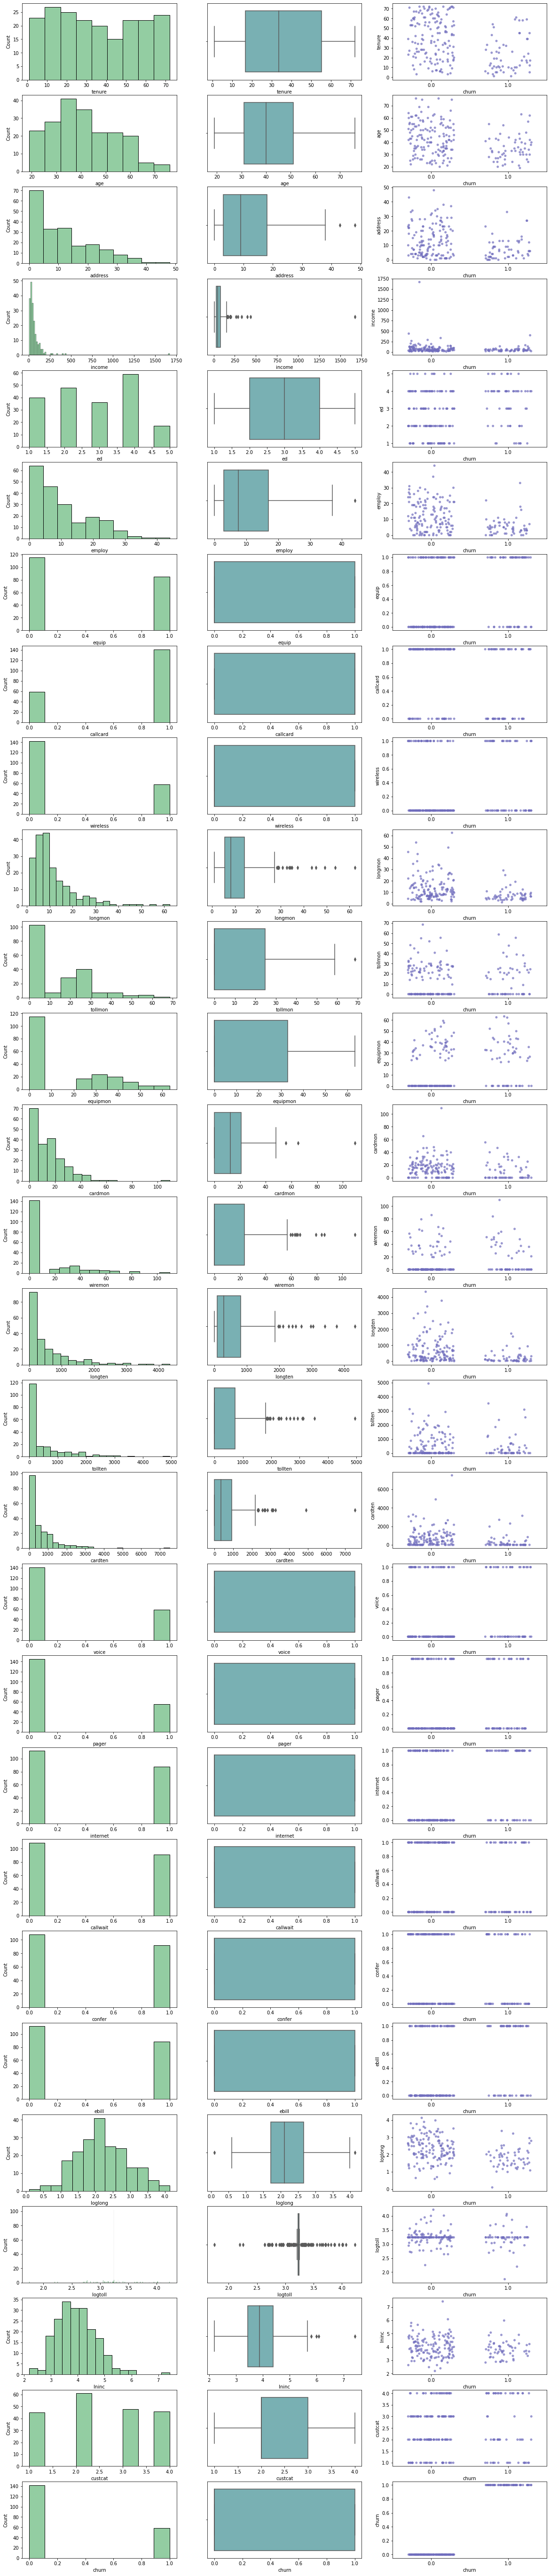

In [6]:
def plot_base_relation(df, figsize=(20, 60)):
    columns = df.columns.tolist()
    _, axs = plt.subplots(len(columns), 3, figsize=figsize)
    
    for idx, column in enumerate(columns):
        # To get distribution of data
        sns.histplot(
            x=df[column],
            kde=False,
            color='#65b87b', alpha=.7,
            ax=axs[idx][0]
        )

        # To get knowledge about outliers
        sns.boxplot(
            x=df[column],
            color='#6fb9bd',
            ax=axs[idx][1]
        )

        # To get its realtion with SalePrice
        sns.stripplot(
            y=column, x='churn', data=df,
            color='#706dbd', alpha=.7, jitter=.3,
            ax=axs[idx][2]
        )
        
        
plot_base_relation(df, figsize=(20, 100))

The above plots shows that many columns suffer the issue for `outliers`

In [7]:
# Removing outliers using IQR method
def rm_outliers_in_col_using_iqr(df, col):
    # col here is df.column_name (or df[column_name])

    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1

    outliers_row_idx = col.loc[
        (col < (Q1 - 1.5 * IQR)) | (col > (Q3 + 1.5 * IQR))
    ].index.tolist()

    df = df.drop(outliers_row_idx, axis='rows')
    return (outliers_row_idx, df)


# Removing outliers using the Zscore method
def rm_outliers_in_col_using_zscore(df, col, column_name):
    # col here is df.column_name (or df[column_name])
    
    zscores_df = pd.DataFrame({
        f'{column_name}': col.to_numpy()
    }, df.index.tolist())
    
    zscores_df['zscores'] = zscores_df.apply(lambda x: zscore(x))
    outliers_row_idx = zscores_df[np.abs(zscores_df.zscores) > 3].index.tolist()

    df = df.drop(outliers_row_idx, axis='rows')
    return (outliers_row_idx, df)


# Remove outliers of a column using iqr & zscore methods
def remove_outliers_of_a_column(df, column_name):
    rm_idxs = []
    for _ in range(10):
        outliers_row_idx, df = rm_outliers_in_col_using_iqr(df, df[column_name])
        rm_idxs.extend(outliers_row_idx)
        
        outliers_row_idx, df = rm_outliers_in_col_using_zscore(df, df[column_name], column_name)
        rm_idxs.extend(outliers_row_idx)
    return rm_idxs, df


# Remove outliers of a df using iqr & zscore methods
def remove_outliers_of_df(df):
    rm_rows_idxs = []
    
    # check if a column is categorical in that case we won't remove outliers
    def is_categorical(column):
        # above 10 the column will be considered as categorical
        return len(column.unique()) > 10
    
    
    for column in df.columns.tolist():
        if column == 'churn' or not is_categorical(df[column]):
            # As we don't want to do anything with `SalePrice`
            continue
            
        rm_idxs, df = remove_outliers_of_a_column(df, column)
        rm_rows_idxs.extend(rm_idxs)
    return rm_rows_idxs, df

In [8]:
# To do the above thing we can just modify the `remove_outliers_of_df` func
def remove_outliers_of_df_with_threshold(df, threshold=4):
    # `threshold` here is the percent above which the entire 
    # column will be dropped 

    rm_rows_idxs = []
    for column in df.columns.tolist():
        if column == 'churn':
            # As we don't want to do anything with `price`
            continue
            
        rm_idxs, tmp_df = remove_outliers_of_a_column(df, column)

        if round(len(rm_idxs) / len(df), 2) * 100 > threshold:
            drop_column(df, column)
        else:
            df = tmp_df.copy()
            del tmp_df
            rm_rows_idxs.extend(rm_idxs)
   
    return rm_rows_idxs, df



with np.errstate(divide='ignore', invalid='ignore'):
    # /opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
    #  return (a - mns) / sstd
    # 
    # To avoid the above error which happens while calculating the zscore as std(sstd) vanishes => (a - mns) / sstd
    
    print('=== Old df info ===')
    print(df.info())
    
    RM_ROWS_IDXS, df = remove_outliers_of_df_with_threshold(df)
    
    print('\n=== New df info ===\n')
    print(df.info())

=== Old df info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tenure    200 non-null    float64
 1   age       200 non-null    float64
 2   address   200 non-null    float64
 3   income    200 non-null    float64
 4   ed        200 non-null    float64
 5   employ    200 non-null    float64
 6   equip     200 non-null    float64
 7   callcard  200 non-null    float64
 8   wireless  200 non-null    float64
 9   longmon   200 non-null    float64
 10  tollmon   200 non-null    float64
 11  equipmon  200 non-null    float64
 12  cardmon   200 non-null    float64
 13  wiremon   200 non-null    float64
 14  longten   200 non-null    float64
 15  tollten   200 non-null    float64
 16  cardten   200 non-null    float64
 17  voice     200 non-null    float64
 18  pager     200 non-null    float64
 19  internet  200 non-null    float64
 20  callwait  20

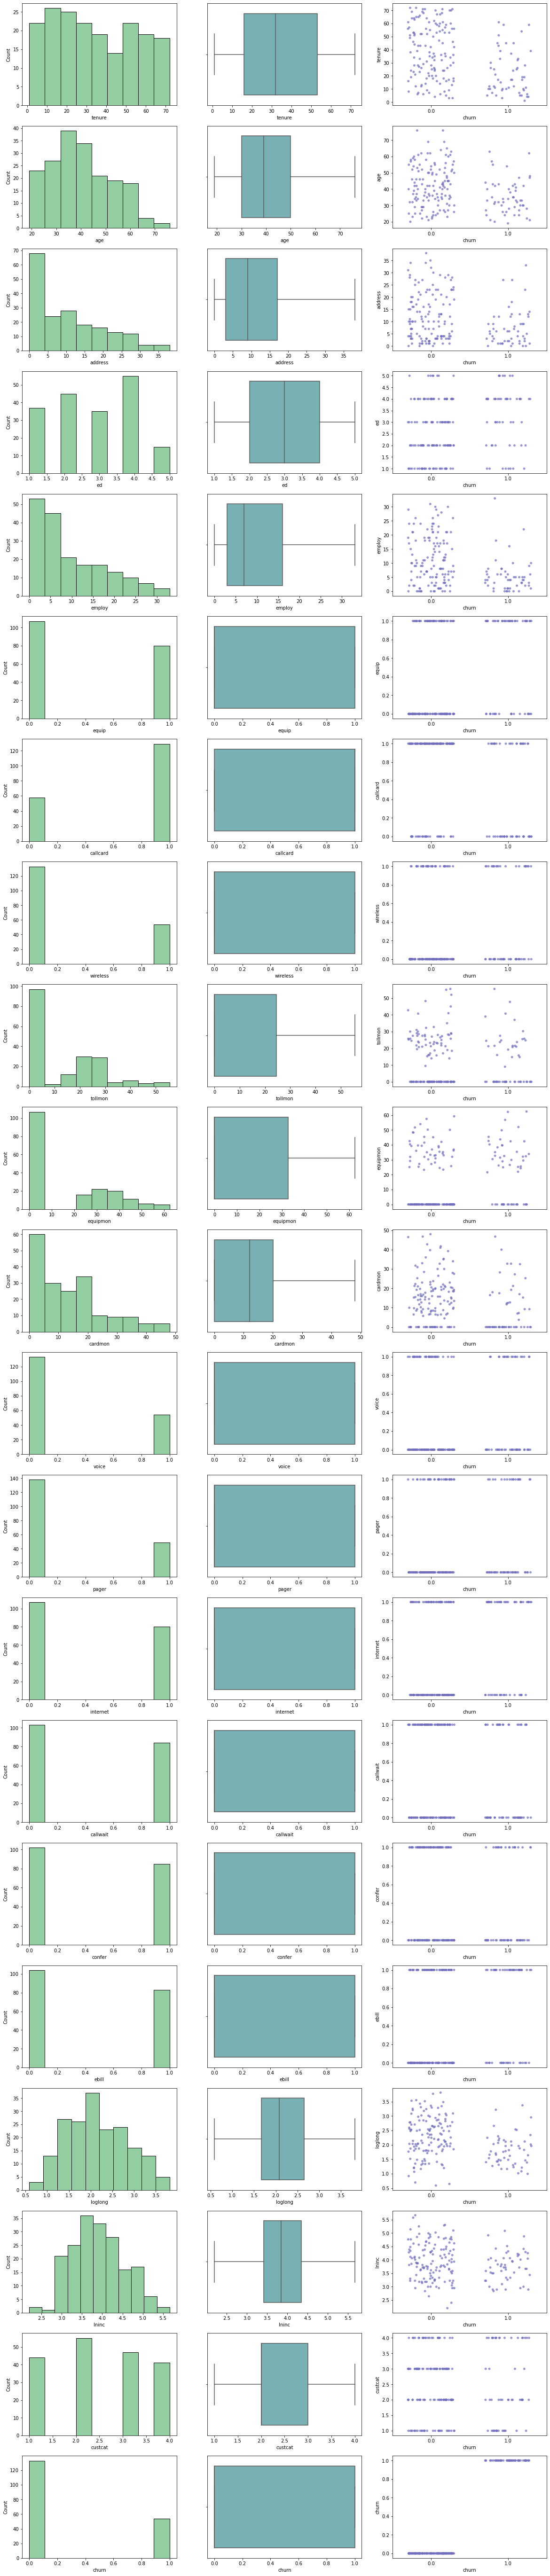

In [9]:
plot_base_relation(df, figsize=(20, 100))

In [10]:
def plot_corr(df, figsize=(12, 6)):
    # the `corr` method uses pearson correaltion
    corr = df.corr()
    
    _, ax = plt.subplots(1, 1, figsize=figsize)
    g = sns.heatmap(corr, ax=ax, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))

    for _ax in g.get_xticklabels():
        _ax.set_rotation(75)

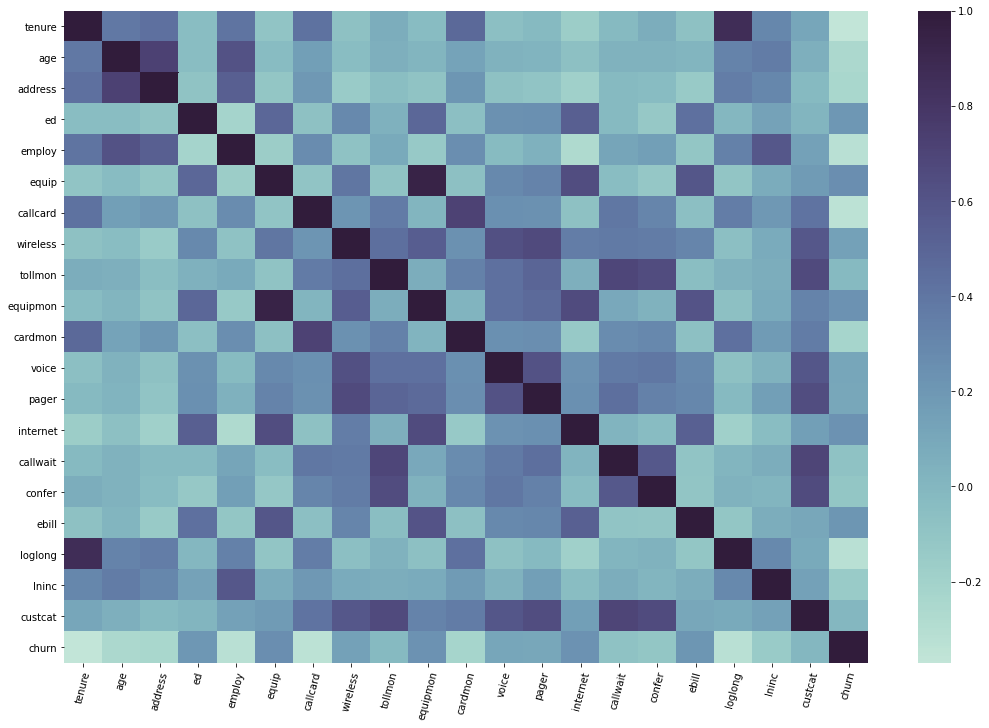

In [11]:
plot_corr(df, figsize=(18, 12))

In [12]:
def get_corr(data_1, data_2):
    return round(pearsonr(data_1, data_2)[0], 2)
    
    
def get_corr_info_for_df(df):
    columns = df.columns.tolist()
    
    # To keep record of which corr info is displayed & hence
    # not to display opposite corr info 
    # eg. if a - b is display then b - a will not be displayed
    # since they will have same result
    displayed = []
    def is_displayed(main_column, secondary_column, displayed_list):
        return any([
            True for tup in displayed_list if 
            (tup[0] == main_column and tup[1] == secondary_column) 
            or 
            (tup[1] == main_column and tup[0] == secondary_column)
        ])
    
    # main column is the one for which we'll find all the corr info
    # related to secondary column
    for main_column in columns:
        for secondary_column in columns:
            if secondary_column != main_column and not is_displayed(main_column, secondary_column, displayed):
                corr = get_corr(df[main_column], df[secondary_column])
                if corr >= .7 or corr <= -.7:
                    # print only if pearson correlation is high (.7 to .9) or very high (.9 to 1)
                    print(f'{secondary_column} - {main_column}: {corr}')
                    displayed.append((main_column, secondary_column))
                    
                    
get_corr_info_for_df(df)

loglong - tenure: 0.86
address - age: 0.72
equipmon - equip: 0.94
cardmon - callcard: 0.72
custcat - callwait: 0.7


## Modelling

<AxesSubplot:xlabel='churn', ylabel='count'>

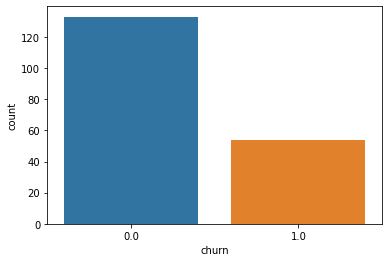

In [13]:
sns.countplot(x='churn', data=df)

The data is `imbalance`

### Balancing the dataset

In [14]:
# Scaling int & float dtype column
def standard_scaler(column):
    # Bumping up the ndim by np.newaxis as column.values is 1D & fit_transform needs 2D
    return StandardScaler().fit_transform(column.values[:, np.newaxis])


# Scaling all int & float dtype columns 
def scaling_df(df):
    # df here should sent as df.copy()
    
    # Selecting columns which have number dtype
    numbers_df = df.select_dtypes(include=[np.int64, np.float64])

    for column_name in numbers_df.columns.tolist():
        df[column_name] = standard_scaler(df[column_name])
    return df

In [15]:
# Splitting the dataset

columns = df.columns.tolist()
columns.remove('churn')

x = df[columns]
y = df['churn']

# Scaling the dataset (df)
x = scaling_df(x.copy())
    
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [16]:
x.sample(5)

,tenure,age,address,ed,employ,equip,callcard,wireless,tollmon,equipmon,cardmon,voice,pager,internet,callwait,confer,ebill,loglong,lninc,custcat
18,1.419825,-1.219256,-0.744480,0.143115,-0.912001,1.156503,0.670531,-0.637193,-0.856930,1.017938,0.648614,-0.637193,-0.595880,-0.864675,-0.903069,1.095445,1.119380,1.488663,0.660036,0.507093
30,-0.250032,-1.139841,-0.425173,-1.431151,-0.312338,-0.864675,0.670531,-0.637193,-0.856930,-0.815680,0.224803,-0.637193,-0.595880,-0.864675,1.107335,-0.912871,-0.893352,-0.418648,-0.568782,0.507093
170,-0.870265,0.686707,0.639183,-0.644018,-0.552203,1.156503,-1.491354,1.569383,0.085594,1.212177,-1.066814,1.569383,1.678191,1.156503,-0.903069,-0.912871,-0.893352,-1.090874,-0.281803,1.436762
49,1.133564,1.401444,-0.105866,-0.644018,0.886988,-0.864675,-1.491354,-0.637193,0.691503,-0.815680,-1.066814,-0.637193,-0.595880,-0.864675,1.107335,1.095445,-0.893352,0.535007,1.015706,0.507093
137,-0.774844,-1.219256,-0.744480,-0.644018,-0.312338,-0.864675,0.670531,-0.637193,0.994457,-0.815680,1.435693,-0.637193,-0.595880,-0.864675,-0.903069,1.095445,-0.893352,-1.407301,-0.977879,-1.352247


In [17]:
skf = StratifiedKFold(n_splits=10)

In [18]:
models = [
    LogisticRegression(), 
    SGDClassifier(), 
    KNeighborsClassifier(), 
    GaussianNB(), 
    # MultinomialNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
]

# not using MultinomialNB to avoid below error

# /opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
# Traceback (most recent call last):
#   File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
#     estimator.fit(X_train, y_train, **fit_params)
#   File "/opt/conda/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 638, in fit
#     self._count(X, Y)
#   File "/opt/conda/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 771, in _count
#     check_non_negative(X, "MultinomialNB (input X)")
#   File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 1068, in check_non_negative
#     raise ValueError("Negative values in data passed to %s" % whom)
# ValueError: Negative values in data passed to MultinomialNB (input X)

#   FitFailedWarning)

Doing the modelling process without balancing the data

In [19]:
for model in models:
    scores = cross_val_score(
        model, 
        
        # /opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
        # 
        # STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
        # 
        # Increase the number of iterations (max_iter) or scale the data as shown in:
        #     https://scikit-learn.org/stable/modules/preprocessing.html
        # Please also refer to the documentation for alternative solver options:
        #     https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
        #  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

        # scalling x to avoid above warning
        StandardScaler().fit_transform(x_train),
        y_train, 
        cv=skf
    )
    print(f'*** {model} ***')
    print(f'Cross Validation mean score: {scores.mean()}')
    print()

*** LogisticRegression() ***
Cross Validation mean score: 0.6846153846153846

*** SGDClassifier() ***
Cross Validation mean score: 0.6538461538461539

*** KNeighborsClassifier() ***
Cross Validation mean score: 0.6846153846153846

*** GaussianNB() ***
Cross Validation mean score: 0.6538461538461539

*** DecisionTreeClassifier() ***
Cross Validation mean score: 0.6538461538461539

*** RandomForestClassifier() ***
Cross Validation mean score: 0.7

*** SVC() ***
Cross Validation mean score: 0.7153846153846155



In [20]:
len(x_train.columns)

20

In [21]:
_smote = SMOTE(random_state=0)
x_train_sm, y_train_sm = _smote.fit_resample(x_train, y_train)
len(x_train_sm)

186

In [22]:
x_train_sm.sample(5)

,tenure,age,address,ed,employ,equip,callcard,wireless,tollmon,equipmon,cardmon,voice,pager,internet,callwait,confer,ebill,loglong,lninc,custcat
164,-1.166953,-1.624089,-1.122203,-0.288896,-1.151866,1.156503,-1.491354,-0.637193,-0.856930,0.657766,-1.066814,-0.637193,-0.595880,1.156503,-0.903069,-0.006801,1.119380,-0.926493,-1.539624,-0.842006
21,0.990433,0.289632,1.384232,-1.431151,1.606583,-0.864675,0.670531,-0.637193,0.792487,-0.815680,0.083532,-0.637193,-0.595880,-0.864675,-0.903069,1.095445,-0.893352,1.013293,0.794366,0.507093
18,0.179360,-0.583935,-0.850915,0.930248,-1.151866,1.156503,0.670531,-0.637193,-0.856930,0.593202,-0.077920,-0.637193,-0.595880,1.156503,-0.903069,-0.912871,1.119380,0.341068,-0.397816,-0.422577
112,0.847303,-0.107444,-0.531609,0.143115,1.006921,-0.864675,0.670531,-0.637193,0.826149,-0.815680,-0.400824,-0.637193,1.678191,-0.864675,-0.903069,-0.912871,1.119380,0.279824,1.343900,-1.352247
110,0.370201,-0.345689,0.319876,-0.644018,0.167393,-0.864675,-1.491354,1.569383,0.927134,-0.815680,-1.066814,-0.637193,1.678191,-0.864675,1.107335,1.095445,-0.893352,-0.310742,-0.174949,0.507093


In [23]:
for model in models:
    scores = cross_val_score(
       model, 
        
        # /opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
        # 
        # STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
        # 
        # Increase the number of iterations (max_iter) or scale the data as shown in:
        #     https://scikit-learn.org/stable/modules/preprocessing.html
        # Please also refer to the documentation for alternative solver options:
        #     https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
        #  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

        # scalling x to avoid above warning
        StandardScaler().fit_transform(x_train_sm),
        y_train_sm, 
        cv=skf
    )
    print(f'*** {model} ***')
    print(f'Cross Validation mean score: {scores.mean()}')
    print()

*** LogisticRegression() ***
Cross Validation mean score: 0.7108187134502923

*** SGDClassifier() ***
Cross Validation mean score: 0.6350877192982456

*** KNeighborsClassifier() ***
Cross Validation mean score: 0.764327485380117

*** GaussianNB() ***
Cross Validation mean score: 0.7055555555555555

*** DecisionTreeClassifier() ***
Cross Validation mean score: 0.7631578947368421

*** RandomForestClassifier() ***
Cross Validation mean score: 0.8187134502923976

*** SVC() ***
Cross Validation mean score: 0.8181286549707603



### Repeating some EDA

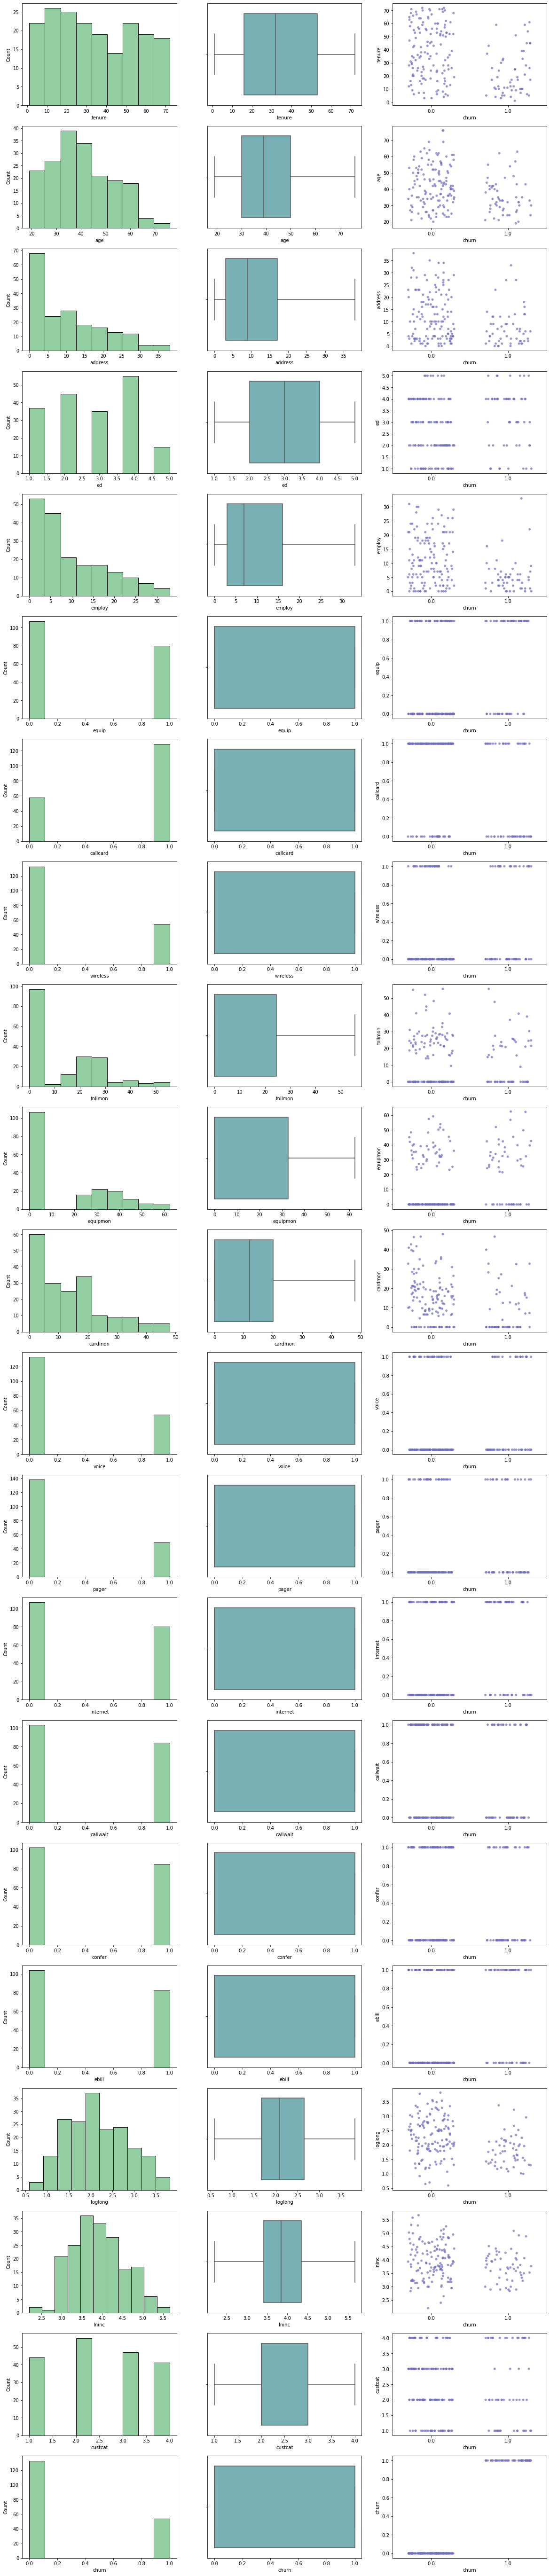

In [24]:
plot_base_relation(df, figsize=(20, 100))

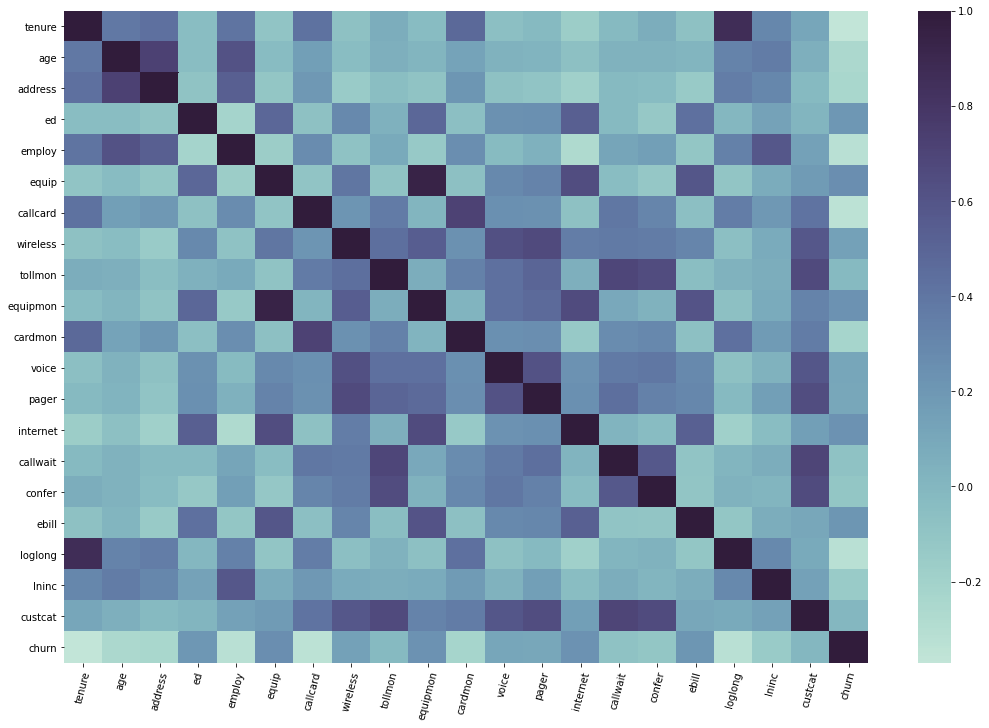

In [25]:
plot_corr(df, figsize=(18, 12))

### Feature Selection

#### Using Backward Elimination for feature selection

In [26]:
x_1 = sm.add_constant(x_train_sm)

# Fitting sm.OLS model
sm_model = sm.OLS(y_train_sm, x_1).fit()
sm_model.pvalues

const      4.204276e-23
tenure     2.694567e-01
age        6.675174e-01
address    8.781338e-01
ed         7.232719e-01
               ...     
confer     9.282094e-02
ebill      6.547885e-01
loglong    4.561345e-01
lninc      9.880243e-02
custcat    4.516806e-01
Length: 21, dtype: float64

In [27]:
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     4.387
Date:                Fri, 02 Apr 2021   Prob (F-statistic):           3.97e-08
Time:                        13:20:39   Log-Likelihood:                -95.342
No. Observations:                 186   AIC:                             232.7
Df Residuals:                     165   BIC:                             300.4
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3972      0.034     11.590      0.0

In [28]:
print(sm_model.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.268   
Dependent Variable: churn            AIC:                232.6836
Date:               2021-04-02 13:20 BIC:                300.4243
No. Observations:   186              Log-Likelihood:     -95.342 
Df Model:           20               F-statistic:        4.387   
Df Residuals:       165              Prob (F-statistic): 3.97e-08
R-squared:          0.347            Scale:              0.18399 
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
const          0.3972    0.0343  11.5900  0.0000   0.3295   0.4649
tenure        -0.0871    0.0786  -1.1080  0.2695  -0.2424   0.0681
age           -0.0246    0.0572  -0.4303  0.6675  -0.1376   0.0884
address        0.0082    0.0535   0.1536  0.8781  -0.0974   0.1139
ed            -0.016

In [29]:
# Backward Elimination

def backward_elminiation(x_train, y_train):
    columns = list(x_train.columns)
    p_max = 1
    
    while len(columns) > 0:
        p = []

        x_1 = x_train[columns]
        x_1 = sm.add_constant(x_1)  # `add_constant`: Add a column of ones to an array
        
        # Fitting sm.OLS model
        model = sm.OLS(y_train, x_1).fit()
        
        # p-values
        p = pd.Series(model.pvalues.values[1:], index=columns)
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        
        # if p-value (significance) 0.05 (5%) then remove the column
        if pmax > 0.05:
            columns.remove(feature_with_p_max)
        else:
            break
            
    selected_features_BE = columns
    return selected_features_BE
        

backward_elminiation_features = backward_elminiation(x_train_sm, y_train_sm)
backward_elminiation_features

['tenure', 'employ', 'tollmon', 'equipmon', 'callwait', 'lninc']

In [30]:
x_train_sm = x_train_sm[backward_elminiation_features]
x_train_sm.sample(5)

,tenure,employ,tollmon,equipmon,callwait,lninc
75,0.227070,-0.672136,-0.856930,-0.815680,-0.903069,-0.977879
63,1.610666,0.287325,-0.856930,0.893625,-0.903069,0.901220
86,0.417911,1.006921,1.886489,1.691301,1.107335,0.165456
157,-1.440845,-0.435526,0.737883,1.755768,1.107335,1.787640
12,-1.490497,-0.792068,0.657841,-0.815680,1.107335,-1.377817


In [31]:
for model in models:
    scores = cross_val_score(model, x_train_sm, y_train_sm,  cv=skf)
    print(f'*** {model} ***')
    print(f'Cross Validation mean score: {scores.mean()}')
    print()

*** LogisticRegression() ***
Cross Validation mean score: 0.7271929824561403

*** SGDClassifier() ***
Cross Validation mean score: 0.6251461988304093

*** KNeighborsClassifier() ***
Cross Validation mean score: 0.7751461988304092

*** GaussianNB() ***
Cross Validation mean score: 0.7485380116959064

*** DecisionTreeClassifier() ***
Cross Validation mean score: 0.83859649122807

*** RandomForestClassifier() ***
Cross Validation mean score: 0.8242690058479532

*** SVC() ***
Cross Validation mean score: 0.765204678362573



In [32]:
def param_selection(x, y, nfolds, model, params_grid):
    grid_search = GridSearchCV(model(), params_grid, cv=nfolds)
    grid_search.fit(x, y)
    
    return (
        grid_search.best_estimator_, 
        grid_search.best_params_, 
        grid_search.best_score_
    )



random_forest_params = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2']
}

decision_tree_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [33]:
best_estimator, best_params, best_score = param_selection(
    x_train_sm, y_train_sm, skf,
    DecisionTreeClassifier, decision_tree_params
)

print(best_estimator)
print(best_params)
print(best_score)

DecisionTreeClassifier(criterion='entropy', max_features='auto',
                       splitter='random')
{'criterion': 'entropy', 'max_features': 'auto', 'splitter': 'random'}
0.7807017543859649


In [34]:
scores = cross_val_score(
    best_estimator, 
    x_train_sm, y_train_sm, 
    cv=skf
)

scores.mean()

0.7760233918128654

In [35]:
model = best_estimator.fit(x_train_sm, y_train_sm)

#### Plotting Learning Curve

In [36]:
_size = np.arange(0.01, 1.01, 0.06)
train_sizes = np.array(_size)
scoring = 'neg_mean_squared_error'

train_sizes_abs, train_scores, cv_scores = learning_curve(
    best_estimator, 
    x_train_sm, y_train_sm, 
    train_sizes=train_sizes, cv=skf, scoring=scoring
)

In [37]:
train_scores_mean = []
for row in train_scores:
    _mean = row.mean()
    train_scores_mean.append(_mean)
    
cv_scores_mean = []
for row in cv_scores:
    _mean = row.mean()
    cv_scores_mean.append(_mean)    
    
train_scores_mean = -np.array(train_scores_mean)
cv_scores_mean = -np.array(cv_scores_mean)

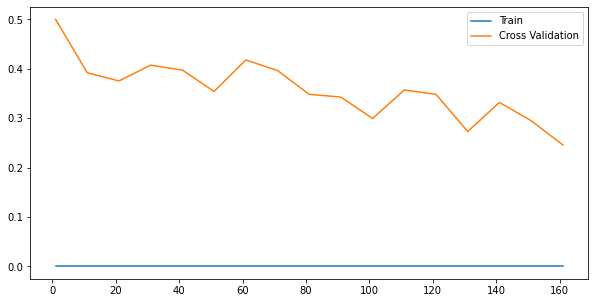

In [38]:
f, ax = plt.subplots(figsize=(10, 5))

ax.plot(train_sizes_abs, train_scores_mean, label='Train')
ax.plot(train_sizes_abs, cv_scores_mean, label='Cross Validation')

ax.legend()

## Evaluation

In [39]:
# Using `backward_elminiation_features` for testing
x_test = x_test[backward_elminiation_features]
x_test.sample(5)

,tenure,employ,tollmon,equipmon,callwait,lninc
164,1.801507,-0.192405,-0.856930,-0.815680,-0.903069,0.324210
58,-0.106901,-1.031933,0.220240,1.393467,-0.903069,0.934803
5,1.610666,1.726516,-0.856930,-0.815680,-0.903069,1.356112
103,0.465621,1.366718,0.842980,-0.815680,1.107335,0.882902
19,-1.061106,-1.151866,0.809318,-0.815680,1.107335,-1.457194


In [40]:
y_test_pred = model.predict(x_test)

In [41]:
print(model.score(x_test, y_test))
print(f1_score(y_test, y_test_pred, average="weighted"))
print(precision_score(y_test, y_test_pred, average="weighted"))
print(recall_score(y_test, y_test_pred, average="weighted"))

0.6666666666666666
0.6693188667872213
0.6723646723646723
0.6666666666666666


In [42]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    '''
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
    '''

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=10)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, format(cm[i, j], fmt),
            horizontalalignment='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76        40
         1.0       0.44      0.47      0.46        17

    accuracy                           0.67        57
   macro avg       0.61      0.61      0.61        57
weighted avg       0.67      0.67      0.67        57

Confusion matrix, without normalization
[[30 10]
 [ 9  8]]


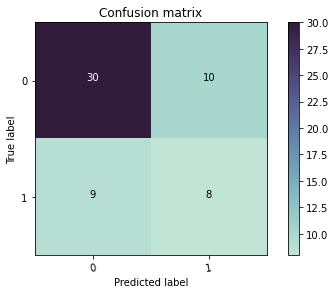

In [43]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
np.set_printoptions(precision=2)

print(classification_report(y_test, y_test_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],normalize= False,  title='Confusion matrix')

In [44]:
# Saving the model
dump(model, 'model.joblib')

['model.joblib']

---

I'll wrap things up there. If you want to find some other answers then go ahead `edit` this kernel. If you have any `questions` then do let me know.

If this kernel helped you then don't forget to 🔼 `upvote` and share your 🎙 `feedback` on improvements of the kernel.

![](https://media.giphy.com/media/PtdOBG0BD9Vvi/giphy.gif)

---